In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

We set the batch_size 32 so all the images are stored in the batch size of 32, 

length of the dataset = total images / batch size
length of the dataset = 2152 / 32
length of the dataset = 67.25 = 68

In [12]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


Shape of the 1st image is 256 x 256 and 3 is chennal color, which is RGB.

In [15]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0]) # image is in tensor, the shape is 256 x 256

tf.Tensor(
[[[194. 191. 198.]
  [193. 190. 197.]
  [195. 192. 199.]
  ...
  [170. 168. 181.]
  [171. 169. 182.]
  [167. 165. 178.]]

 [[187. 184. 191.]
  [189. 186. 193.]
  [196. 193. 200.]
  ...
  [167. 165. 178.]
  [169. 167. 180.]
  [171. 169. 182.]]

 [[188. 185. 192.]
  [190. 187. 194.]
  [196. 193. 200.]
  ...
  [161. 159. 172.]
  [163. 161. 174.]
  [173. 171. 184.]]

 ...

 [[172. 167. 174.]
  [158. 153. 160.]
  [146. 141. 148.]
  ...
  [102.  99. 110.]
  [133. 130. 141.]
  [117. 114. 125.]]

 [[151. 146. 153.]
  [151. 146. 153.]
  [153. 148. 155.]
  ...
  [130. 127. 138.]
  [116. 113. 124.]
  [124. 121. 132.]]

 [[129. 124. 131.]
  [150. 145. 152.]
  [168. 163. 170.]
  ...
  [128. 125. 136.]
  [118. 115. 126.]
  [156. 153. 164.]]], shape=(256, 256, 3), dtype=float32)


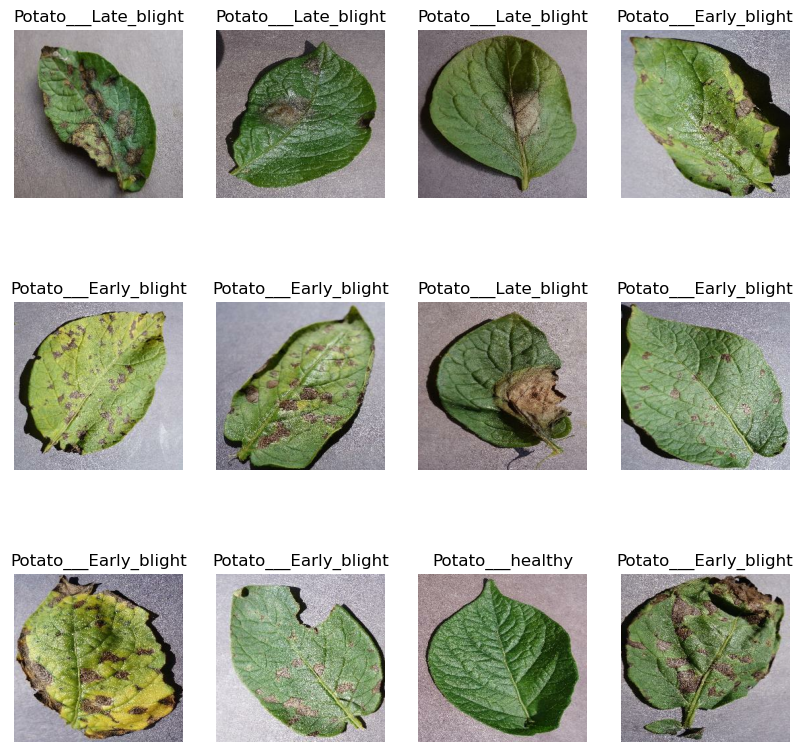

In [24]:
plt.figure(figsize=(10,10))

for image_batch, leble_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[leble_batch[i]])
        plt.axis("off")

## Splitting the data

In [25]:
EPOCH = 50

80% = training
10% = validation
10% = test

In [27]:
# Getting actual number of training data
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [28]:
# first 54 are training data
train_ds = dataset.take(54)
len(train_ds)

54

In [29]:
# Other data is for testing and validation
test_ds = dataset.skip(54)
len(test_ds)

14

In [31]:
# Splitting 10% for validation
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [32]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [34]:
# actual test dataset
test_ds = test_ds.skip(6)
len(test_ds)

2

In [35]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(val_ds)

6

In [40]:
# Optimize datasets so machine could run faster
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [43]:
# For final model we need images in 256 x 256; if user gives any image other than this dimention we need to resize it
# Creating a layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [44]:
# Creating a layer for flip and rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])